In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Initialize constants
goal = 100
gamma = 1.0
prob_roll = 1/6  # Probability of rolling any number on a 6-sided die

In [2]:
# 2. Initialize value function and policy
V = np.zeros(goal + 1)
policy = np.zeros(goal + 1, dtype=int)  # 0 for "stop", 1 for "roll"

In [3]:
# 3. Design a DiceGame Environment
class DiceGameEnvironment:
    def __init__(self, goal=100):
        self.goal = goal

    # 4. Define reward function
    def reward(self, state, action):
        """
        Calculate reward for a given state and action.
        :param state: Current score
        :param action: 0 for stop, 1 for roll
        :return: Reward (1 if goal is reached, 0 otherwise)
        """
        if action == 0:  # stop
            return 1 if state == self.goal else 0
        else:  # roll
            return 0  # No immediate reward for rolling

    def transition(self, state, action):
        """
        Determine possible next states and rewards for a given state and action.
        :param state: Current score
        :param action: 0 for stop, 1 for roll
        :return: List of (next_state, reward, done) tuples
        """
        if action == 0:  # stop
            return [(state, self.reward(state, action), True)]

        # action == 1 (roll)
        outcomes = []
        for roll in range(1, 7):
            new_state = min(state + roll, self.goal) if roll > 1 else 0
            done = new_state == self.goal or new_state == 0
            reward = self.reward(new_state, 0) if done else 0
            outcomes.append((new_state, reward, done))
        return outcomes


In [4]:
# 5. Policy Iteration Function
def policy_iteration(env, V, policy, max_iterations=1000):
    """
    Perform policy iteration to find the optimal policy and value function.
    :param env: DiceGameEnvironment instance
    :param V: Initial value function
    :param policy: Initial policy
    :param max_iterations: Maximum number of iterations
    :return: Optimal value function, optimal policy, number of iterations
    """
    for iteration in range(max_iterations):
        # Policy Evaluation
        for s in range(env.goal + 1):
            if s == env.goal:
                continue
            action = policy[s]
            if action == 0:  # stop
                V[s] = env.reward(s, 0)
            else:  # roll
                outcomes = env.transition(s, 1)
                V[s] = sum(prob_roll * (r + gamma * V[s_next]) for s_next, r, _ in outcomes)

        # Policy Improvement
        stable = True
        for s in range(env.goal + 1):
            if s == env.goal:
                continue
            old_action = policy[s]
            stop_value = env.reward(s, 0)
            roll_outcomes = env.transition(s, 1)
            roll_value = sum(prob_roll * (r + gamma * V[s_next]) for s_next, r, _ in roll_outcomes)
            policy[s] = 0 if stop_value >= roll_value else 1

            if old_action != policy[s]:
                stable = False

        if stable:
            break

    return V, policy, iteration + 1


In [5]:
# 6. Value Iteration Function
def value_iteration(env, V, epsilon=0.001, max_iterations=1000):
    """
    Perform value iteration to find the optimal value function and policy.
    :param env: DiceGameEnvironment instance
    :param V: Initial value function
    :param epsilon: Convergence threshold
    :param max_iterations: Maximum number of iterations
    :return: Optimal value function, optimal policy, number of iterations
    """
    for iteration in range(max_iterations):
        delta = 0
        for s in range(env.goal + 1):
            if s == env.goal:
                continue
            v = V[s]
            stop_value = env.reward(s, 0)
            roll_outcomes = env.transition(s, 1)
            roll_value = sum(prob_roll * (r + gamma * V[s_next]) for s_next, r, _ in roll_outcomes)
            V[s] = max(stop_value, roll_value)
            delta = max(delta, abs(v - V[s]))

        if delta < epsilon:
            break

    # Extract policy from value function
    policy = np.zeros(env.goal + 1, dtype=int)
    for s in range(env.goal + 1):
        if s == env.goal:
            continue
        stop_value = env.reward(s, 0)
        roll_outcomes = env.transition(s, 1)
        roll_value = sum(prob_roll * (r + gamma * V[s_next]) for s_next, r, _ in roll_outcomes)
        policy[s] = 0 if stop_value >= roll_value else 1

    return V, policy, iteration + 1


In [6]:
# 7. Executing Policy Iteration and Value Iteration
env = DiceGameEnvironment(goal)

print("Policy Iteration:")
V_pi, policy_pi, iterations_pi = policy_iteration(env, V.copy(), policy.copy())
print(f"Converged in {iterations_pi} iterations")

print("\nValue Iteration:")
V_vi, policy_vi, iterations_vi = value_iteration(env, V.copy())
print(f"Converged in {iterations_vi} iterations")

# Function to simulate the game using a given policy
def simulate_game(env, policy, num_games=100):
    """
    Simulate the dice game using a given policy.
    :param env: DiceGameEnvironment instance
    :param policy: Policy to follow
    :param num_games: Number of games to simulate
    :return: Average reward over all simulated games
    """
    total_reward = 0
    for _ in range(num_games):
        state = 0
        done = False
        while not done:
            action = policy[state]
            if action == 0:  # stop
                reward = env.reward(state, action)
                total_reward += reward
                done = True
            else:  # roll
                roll = np.random.randint(1, 7)
                if roll == 1:
                    state = 0
                    done = True
                else:
                    state = min(state + roll, env.goal)
                    if state == env.goal:
                        total_reward += 1
                        done = True
    return total_reward / num_games

print("\nSimulation Results:")
print(f"Average reward using Policy Iteration: {simulate_game(env, policy_pi)}")
print(f"Average reward using Value Iteration: {simulate_game(env, policy_vi)}")


Policy Iteration:
Converged in 18 iterations

Value Iteration:
Converged in 373 iterations

Simulation Results:
Average reward using Policy Iteration: 0.0
Average reward using Value Iteration: 0.02


In [7]:
# 8. Print the Learned Optimal Policy and Optimal Value Function
print("\nLearned Optimal Policy:")
print(policy_vi)
print("\nOptimal Value Function:")
print(V_vi)


Learned Optimal Policy:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]

Optimal Value Function:
[0.51992859 0.52033232 0.52058053 0.52084004 0.52111139 0.5213951
 0.52169174 0.52200189 0.52232619 0.52266526 0.52301978 0.52339046
 0.52377804 0.52418327 0.52460698 0.52504999 0.52551319 0.52599751
 0.52650389 0.52703335 0.52758694 0.52816576 0.52877096 0.52940374
 0.53006535 0.53075712 0.53148041 0.53223667 0.53302739 0.53385415
 0.53471858 0.53562241 0.53656743 0.53755551 0.53858863 0.53966882
 0.54079825 0.54197914 0.54321386 0.54450484 0.54585465 0.54726598
 0.54874163 0.55028453 0.55189774 0.55358448 0.55534808 0.55719205
 0.55912006 0.56113593 0.56324367 0.56544747 0.5677517  0.57016094
 0.57267998 0.57531381 0.57806767 0.58094705 0.58395766 0.58710545
 0.59039667 0.59383784 0.59743595 0.60119811 0.60513163 0.6092442
 0.613544

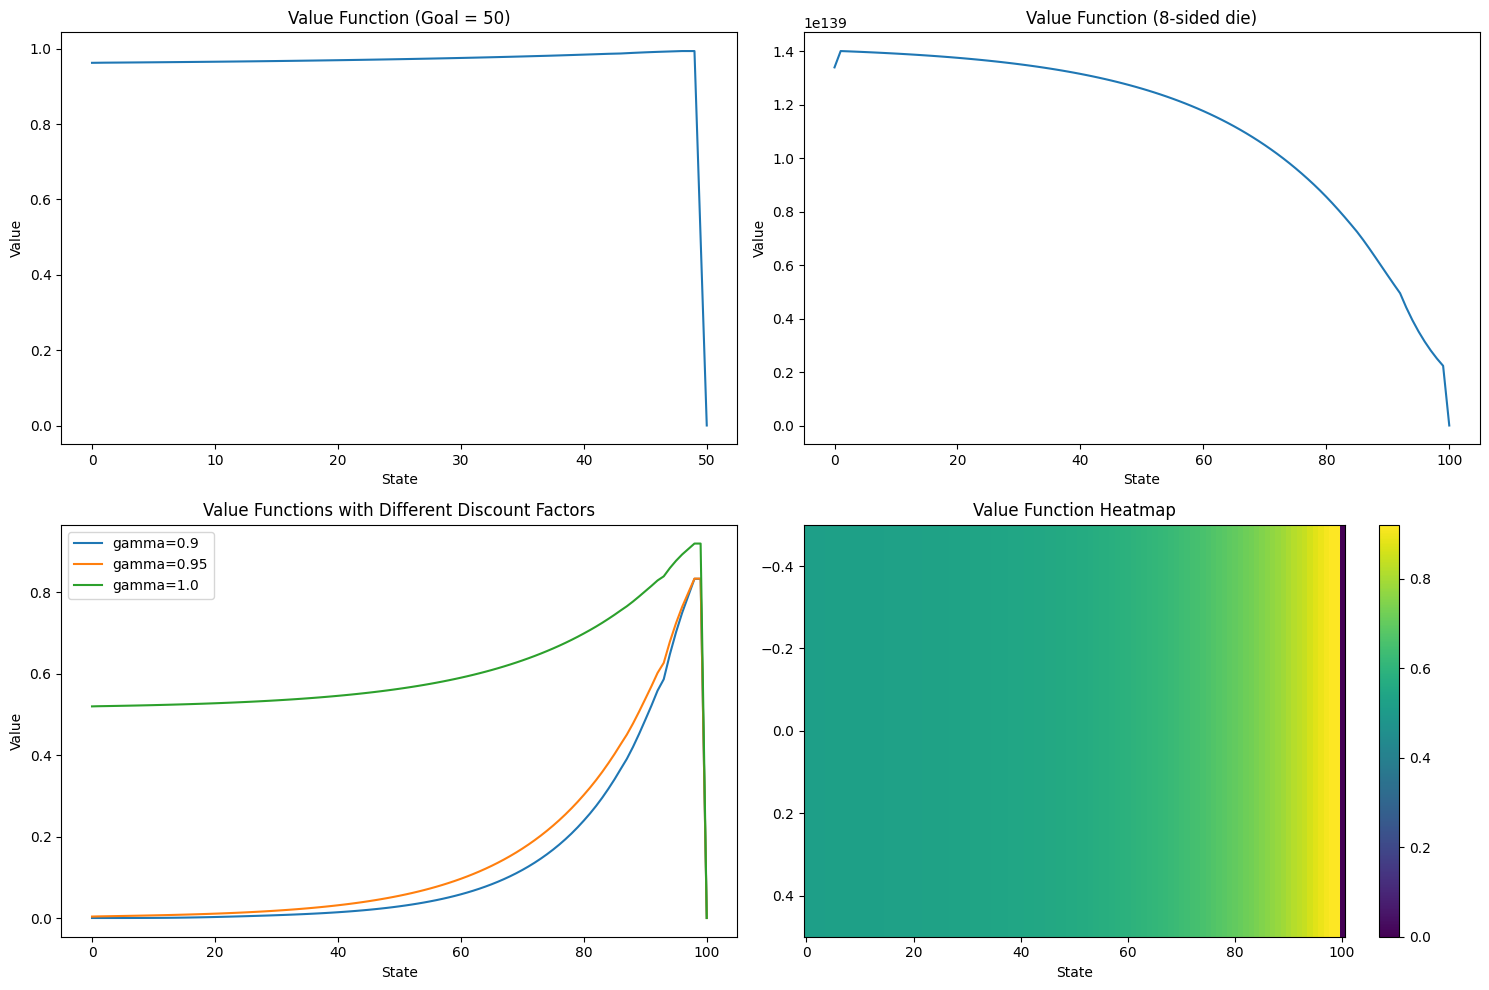

In [8]:
# 9. Change in environment details
def experiment_with_changes():
    """
    Experiment with changes in the environment and visualize results.
    """
    # Change goal to 50
    env_50 = DiceGameEnvironment(50)
    V_50, policy_50, _ = value_iteration(env_50, np.zeros(51))

    # 8-sided die
    class DiceGame8Sided(DiceGameEnvironment):
        def transition(self, state, action):
            if action == 0:  # stop
                return [(state, self.reward(state, action), True)]

            outcomes = []
            for roll in range(8):
                new_state = min(state + roll, self.goal) if roll > 0 else 0
                done = new_state == self.goal or new_state == 0
                reward = self.reward(new_state, 0) if done else 0
                outcomes.append((new_state, reward, done))
            return outcomes

    env_8sided = DiceGame8Sided(100)
    V_8sided, policy_8sided, _ = value_iteration(env_8sided, np.zeros(101))

    # Different discount factors
    gammas = [0.9, 0.95, 1.0]
    V_discounts = []
    for g in gammas:
        global gamma
        gamma = g
        V, _, _ = value_iteration(env, np.zeros(101))
        V_discounts.append(V)

    # Visualizations
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(V_50)
    plt.title("Value Function (Goal = 50)")
    plt.xlabel("State")
    plt.ylabel("Value")

    plt.subplot(2, 2, 2)
    plt.plot(V_8sided)
    plt.title("Value Function (8-sided die)")
    plt.xlabel("State")
    plt.ylabel("Value")

    plt.subplot(2, 2, 3)
    for i, g in enumerate(gammas):
        plt.plot(V_discounts[i], label=f"gamma={g}")
    plt.title("Value Functions with Different Discount Factors")
    plt.xlabel("State")
    plt.ylabel("Value")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.imshow([V_vi], aspect='auto', cmap='viridis')
    plt.title("Value Function Heatmap")
    plt.xlabel("State")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

experiment_with_changes()